# BERT Prediction Error Analysis

This code is used to:
- Verify the impact from text preprocessing on BERT.
- Utilize the unsupervised learning to look for the patterns of error data

In order to speed up the issue analysis, only 1% of total training data(random sampling) is used.

### Coding for Chapter 4.2.3.4 - Additional error analysis

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AdamW,get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from text_preprocessing import preprocess_text
from text_preprocessing import check_spelling,remove_stopword,lemmatize_word

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Import helper functions

from helper import train_dev_test, convert_examples_to_inputs,get_data_loader,data_evaluation,duple_labels,elbow_plot,train

In [4]:
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Enable logging.
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

##### Import dataset

In [7]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.01
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

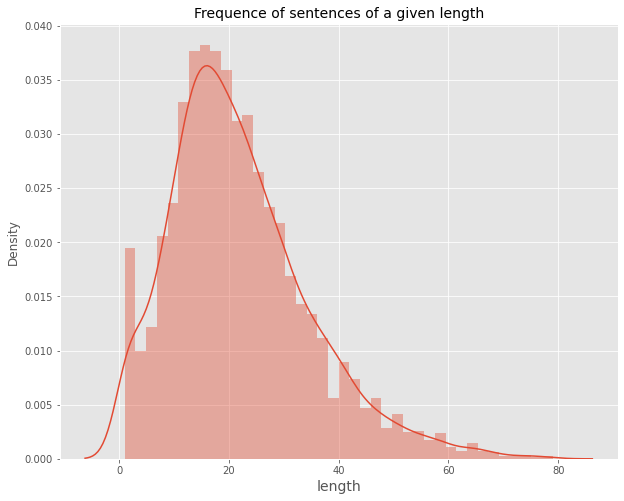

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [9]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    4168.000000
mean       21.913628
std        12.775337
min         1.000000
25%        13.000000
50%        20.000000
75%        29.000000
max        79.000000
Name: original_text, dtype: float64


#### Verify the impact from text preprocessing

The following situations will be considered respectively:
- Initial status - Pretrain: evaluate the test dataset without training.
- Fine tune without preprocessing: train the bert, then evaluate the test dataset.
- Remove stopwords,train the bert, then evaluate the test dataset.
- Correct mis-spelling,train the bert, then evaluate the test dataset.
- Lemmanization,train the bert, then evaluate the test dataset.
- Remove duplicate records (same label),train the bert, then evaluate the test dataset.
- Remove duplicated records ( different label),train the bert, then evaluate the test dataset.


In [10]:
# Initalize the parameters for training / evaluation
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
BERT_MODEL = "distilbert-base-uncased"
OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"

In [11]:
df_acc=pd.DataFrame(columns=['description','accuracy','texts','labels','prediction'])
list_acc=['Pretrain','Fine tune without preprocessing',
                       'Removal of stopwords','Correction of spelling',
                      'Lemmatization','Removal of duplicate records with same labels',
                      'Removal of duplicate records with different labels']

In [13]:
for i in range(len(list_acc)):
    ### prepare for data based on different situation
    process_data=train_data.copy()
    if list_acc[i]=='Removal of stopwords':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))  
    
    if list_acc[i]=='Removal of stopwords':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(check_spelling(x)) if type(x)=='str' else x) 

    if list_acc[i]=='Correction of spelling':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))      
       
    if list_acc[i]=='Removal of duplicate records with same labels':
        process_data.drop_duplicates(subset=['original_text','label'],inplace=True)

    if list_acc[i]=='Removal of duplicate records with different labels':
        # look for the records with different labels 
        df_2labels=process_data.copy()
        df_duple_labels=duple_labels(df_2labels)
        # Indentify double labels in data
        df_2labels['duplicated']=df_2labels.duplicated(subset=['original_text'])
        df_2labels=df_2labels.merge(df_duple_labels,how="left",left_on="original_text",right_on="original_text")
        df_2labels['label_y']=df_2labels['label_y'].apply(lambda x: '0' if pd.isnull(x) else '1') # 0 means 1 label, 1 means 2 labels
        df_2labels=pd.DataFrame(df_2labels[['original_text','label_x','label_y','duplicated']])
        df_2labels.columns=['original_text','label','dulabel','duplicated']
        process_data=df_2labels[df_2labels['dulabel']=='0'].copy()

    _,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),\
                                        (target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

    ### Train model if it is not in "pretrain"
    if list_acc[i]!='Pretrain':
        print("In training:",list_acc[i] )
        train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)
        train_flag=True
    else:
        train_flag=False

    ### Evaluate model
    print("In evaluating:",list_acc[i] )
    _,pred,acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=train_flag,OUTPUT_DIR = OUTPUT_DIR, 
                               MODEL_FILE_NAME = MODEL_FILE_NAME)
    
    ### Save the output including dataset, accuracy results.
    df_acc.at[i,'description']=list_acc[i]
    df_acc.at[i,'accuracy']=acc
    df_acc.at[i,'texts']=(train_texts,dev_texts,test_texts)
    df_acc.at[i,'labels']=(train_labels,dev_labels,test_labels)
    df_acc.at[i,'prediction']=pred

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In evaluating: Pretrain


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.4724220623501199, 0.4724220623501199, 0.4724220623501199, None)
              precision    recall  f1-score   support

           0       0.44      0.43      0.44       196
           1       0.50      0.51      0.50       221

    accuracy                           0.47       417
   macro avg       0.47      0.47      0.47       417
weighted avg       0.47      0.47      0.47       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Fine tune without preprocessing


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6143752944966158


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:45, 40.78s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6143752944966158]
Dev loss: 0.5851307734847069


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:04, 40.76s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.50s/it]

Loss history: [0.6143752944966158, 0.5851307734847069]
Dev loss: 0.66998141258955


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.96s/it]

Loss history: [0.6143752944966158, 0.5851307734847069, 0.66998141258955]
Dev loss: 1.010676232477029
No improvement on development set. Finish training.
In evaluating: Fine tune without preprocessing


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.7050359712230215, 0.7050359712230215, 0.7050359712230215, None)
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       196
           1       0.68      0.85      0.75       221

    accuracy                           0.71       417
   macro avg       0.72      0.70      0.69       417
weighted avg       0.72      0.71      0.70       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Removal of stopwords


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6186215231815974


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:44, 40.67s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6186215231815974]
Dev loss: 0.589405736575524


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:03, 40.60s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:21, 40.24s/it]

Loss history: [0.6186215231815974, 0.589405736575524]
Dev loss: 0.6127695143222809


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:28, 53.68s/it]

Loss history: [0.6186215231815974, 0.589405736575524, 0.6127695143222809]
Dev loss: 0.9483180548995733
No improvement on development set. Finish training.
In evaluating: Removal of stopwords


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6498800959232613, 0.6498800959232613, 0.6498800959232613, None)
              precision    recall  f1-score   support

           0       0.60      0.76      0.67       196
           1       0.72      0.56      0.63       221

    accuracy                           0.65       417
   macro avg       0.66      0.66      0.65       417
weighted avg       0.66      0.65      0.65       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Correction of spelling


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.622835498303175


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:45, 40.73s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.622835498303175]
Dev loss: 0.5962712690234184


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.92s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.44s/it]

Loss history: [0.622835498303175, 0.5962712690234184]
Dev loss: 0.6690071324507395


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.94s/it]

Loss history: [0.622835498303175, 0.5962712690234184, 0.6690071324507395]
Dev loss: 0.9706849120557308
No improvement on development set. Finish training.
In evaluating: Correction of spelling


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6378896882494005, 0.6378896882494005, 0.6378896882494005, None)
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       196
           1       0.72      0.52      0.61       221

    accuracy                           0.64       417
   macro avg       0.65      0.65      0.64       417
weighted avg       0.66      0.64      0.63       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Lemmatization


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.627787172794342


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:46, 40.87s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.627787172794342]
Dev loss: 0.6223559690018495


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.87s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.53s/it]

Loss history: [0.627787172794342, 0.6223559690018495]
Dev loss: 0.673325398315986


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.99s/it]

Loss history: [0.627787172794342, 0.6223559690018495, 0.673325398315986]
Dev loss: 1.006446768840154
No improvement on development set. Finish training.
In evaluating: Lemmatization


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.7026378896882494, 0.7026378896882494, 0.7026378896882494, None)
              precision    recall  f1-score   support

           0       0.79      0.51      0.61       196
           1       0.67      0.88      0.76       221

    accuracy                           0.70       417
   macro avg       0.73      0.69      0.69       417
weighted avg       0.72      0.70      0.69       417

{0: 0, 1: 1}
Train size: 3320
Dev size: 369
Test size: 410
In training: Removal of duplicate records with same labels


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6534373288353285


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:40, 40.13s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6534373288353285]
Dev loss: 0.5381210918227831


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:20<04:00, 40.13s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [01:59<03:19, 39.89s/it]

Loss history: [0.6534373288353285, 0.5381210918227831]
Dev loss: 0.691765925148502


Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:39<04:25, 53.17s/it]

Loss history: [0.6534373288353285, 0.5381210918227831, 0.691765925148502]
Dev loss: 0.9486190353830656
No improvement on development set. Finish training.
In evaluating: Removal of duplicate records with same labels


Evaluation iteration:   0%|          | 0/26 [00:00<?, ?it/s]

Errors performance: (0.7073170731707317, 0.7073170731707317, 0.7073170731707317, None)
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       197
           1       0.69      0.79      0.74       213

    accuracy                           0.71       410
   macro avg       0.71      0.70      0.70       410
weighted avg       0.71      0.71      0.70       410

Records with different labels: 0.02%
{0: 0, 1: 1}
Train size: 3373
Dev size: 375
Test size: 417
In training: Removal of duplicate records with different labels


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6200850730141004


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:44, 40.68s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6200850730141004]
Dev loss: 0.5746928888062636


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.90s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.46s/it]

Loss history: [0.6200850730141004, 0.5746928888062636]
Dev loss: 0.6370340834061304


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.91s/it]

Loss history: [0.6200850730141004, 0.5746928888062636, 0.6370340834061304]
Dev loss: 0.7617807450393835
No improvement on development set. Finish training.
In evaluating: Removal of duplicate records with different labels


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6642685851318945, 0.6642685851318945, 0.6642685851318945, None)
              precision    recall  f1-score   support

           0       0.62      0.88      0.72       209
           1       0.79      0.45      0.57       208

    accuracy                           0.66       417
   macro avg       0.70      0.66      0.65       417
weighted avg       0.70      0.66      0.65       417



In [33]:
#df_acc['accuracy']=round(df_acc['accuracy'],.3)
import altair as alt
bars = alt.Chart(df_acc).mark_bar().encode(
    x='accuracy:Q',
    y="description:O"
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='accuracy:Q'
)

rule = alt.Chart(df_acc[df_acc['description']=='Pretrain']).mark_rule(color='red').encode(
    x='accuracy:Q'
)
(bars + text + rule).properties(title='Comparison of Accuracy',height=400,width=500)

alt.LayerChart(...)

### Coding for Chapter 6.1 - Discussion - findings on label and pretrain model

Compare the embeddings between error records in test set with training set + test set ( including error record), find out the similar 
records,display the numbers of different labels to check whether the portion of label could impact the classification records.

In [34]:
# Introduce sentence-BERT
from sentence_transformers import SentenceTransformer
onlinemodel='all-mpnet-base-v2'
embedder = SentenceTransformer(onlinemodel)

10/24/2022 21:58:20 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: all-mpnet-base-v2
10/24/2022 21:58:23 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda


In [56]:
df_acc[df_acc['description']=='Fine tune without preprocessing']['prediction'].values[0]

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [57]:
df_test=pd.DataFrame(columns=['original_text','label','err','init_pred','best_pred','cnt_1','cnt_0','avg_1','avg_0'])
df_test['original_text']=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][2]
df_test['label']=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][2]
df_test['init_pred']=df_acc[df_acc['description']=='Pretrain']['prediction'].values[0]
df_test['best_pred']=df_acc[df_acc['description']=='Fine tune without preprocessing']['prediction'].values[0]
df_test['err']=df_test['best_pred']-df_test['label']
df_test['err']=df_test['err'].apply(lambda x: 1 if x!=0 else x)

Compare the embeddings between error records in test set with training set + test set ( including error record), find out the similar 
records,display the numbers of different labels to check whether the portion of label could impact the classification records.

In [60]:
## Create the dataset for comparison,

# Create training set
df_comp=pd.DataFrame()
df_comp['original_text']=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][0]
df_comp['label']=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][0]
df_comp=df_comp.reset_index()

# Test dataset
df_test['id']=df_test.index
df_test['id']=df_test['id'].apply(lambda x: 'e'+str(x))

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
## Create the embedding for comparison dataset
query_embeddings=embedder.encode(df_comp['original_text'])

In [62]:
## Work out the similarity clusters and identify the record of self
from sklearn.metrics.pairwise import cosine_similarity

# Set the simlarity threshold 
THRESHOLD=0.5

#Create dateset to cluster the similar sentence
err_cluster=pd.DataFrame(columns=list(df_comp.columns)+['score','cluster'])
df_err=df_test[df_test['err']==1]

for i in trange(len(df_err)):
    df_temp=pd.DataFrame(columns=err_cluster.columns)
    str_to_predict=df_test[df_test['err']==1]['original_text'].iloc[i]
    # Compare similarity
    sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
    j=np.argmax(sim)
    sim_rows=list(np.where(sim[0]>THRESHOLD)[0])
    # cluster the sentences in training set by error records
    if sim_rows !=[]:
        if err_cluster.empty:
            df_temp=df_comp.iloc[sim_rows]
        else:
            df_temp=df_comp.iloc[sim_rows]
        if df_temp.empty== False:
            df_temp['score']=sim[0][sim_rows]
            df_temp['cluster']=df_err['id'].iloc[i]          
            err_cluster=pd.concat([err_cluster,df_temp],axis=0,ignore_index=True)


  0%|                                                                                          | 0/123 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/123 [00:00<00:19,  6.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|█▎                                                                                | 2/123 [00:00<00:18,  6.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  2%|██                                                                                | 3/123 [00:00<00:17,  6.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  3%|██▋                                                                               | 4/123 [00:00<00:16,  7.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  4%|███▎                                                                              | 5/123 [00:00<00:15,  7.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|████                                                                              | 6/123 [00:00<00:15,  7.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|█████▎                                                                            | 8/123 [00:01<00:13,  8.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  7%|██████                                                                            | 9/123 [00:01<00:12,  8.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  9%|███████▏                                                                         | 11/123 [00:01<00:11,  9.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███████▉                                                                         | 12/123 [00:01<00:11,  9.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 11%|█████████▏                                                                       | 14/123 [00:01<00:10, 10.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 13%|██████████▌                                                                      | 16/123 [00:01<00:10, 10.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 15%|███████████▊                                                                     | 18/123 [00:01<00:10, 10.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 16%|█████████████▏                                                                   | 20/123 [00:02<00:10, 10.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 18%|██████████████▍                                                                  | 22/123 [00:02<00:09, 10.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|███████████████▊                                                                 | 24/123 [00:02<00:09, 10.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 21%|█████████████████                                                                | 26/123 [00:02<00:09, 10.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██████████████████▍                                                              | 28/123 [00:02<00:09, 10.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|███████████████████▊                                                             | 30/123 [00:03<00:09, 10.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 26%|█████████████████████                                                            | 32/123 [00:03<00:08, 10.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██████████████████████▍                                                          | 34/123 [00:03<00:08, 10.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████████████████▋                                                         | 36/123 [00:03<00:08, 10.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|█████████████████████████                                                        | 38/123 [00:03<00:08, 10.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 33%|██████████████████████████▎                                                      | 40/123 [00:04<00:08, 10.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 34%|███████████████████████████▋                                                     | 42/123 [00:04<00:08,  9.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 35%|████████████████████████████▎                                                    | 43/123 [00:04<00:08,  9.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|████████████████████████████▉                                                    | 44/123 [00:04<00:08,  9.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|█████████████████████████████▋                                                   | 45/123 [00:04<00:08,  9.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|██████████████████████████████▉                                                  | 47/123 [00:04<00:07, 10.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 39%|███████████████████████████████▌                                                 | 48/123 [00:04<00:07,  9.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████████████████████████████████▎                                                | 49/123 [00:05<00:07,  9.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 41%|████████████████████████████████▉                                                | 50/123 [00:05<00:08,  9.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|█████████████████████████████████▌                                               | 51/123 [00:05<00:08,  8.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|██████████████████████████████████▏                                              | 52/123 [00:05<00:08,  8.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 43%|██████████████████████████████████▉                                              | 53/123 [00:05<00:08,  8.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 44%|███████████████████████████████████▌                                             | 54/123 [00:05<00:07,  8.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████████████████████████████████████▏                                            | 55/123 [00:05<00:07,  9.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 46%|█████████████████████████████████████▌                                           | 57/123 [00:05<00:06,  9.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████████████████████████▏                                          | 58/123 [00:06<00:07,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████████████████████████▌                                         | 60/123 [00:06<00:06,  9.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 50%|████████████████████████████████████████▏                                        | 61/123 [00:06<00:06,  9.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 50%|████████████████████████████████████████▊                                        | 62/123 [00:06<00:06,  9.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████▍                                       | 63/123 [00:06<00:06,  9.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 52%|██████████████████████████████████████████▏                                      | 64/123 [00:06<00:06,  9.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|██████████████████████████████████████████▊                                      | 65/123 [00:06<00:06,  9.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 54%|████████████████████████████████████████████                                     | 67/123 [00:07<00:05,  9.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▊                                    | 68/123 [00:07<00:05,  9.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 57%|██████████████████████████████████████████████                                   | 70/123 [00:07<00:05,  9.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 58%|██████████████████████████████████████████████▊                                  | 71/123 [00:07<00:05,  9.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████                                 | 73/123 [00:07<00:05,  9.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 61%|█████████████████████████████████████████████████▍                               | 75/123 [00:07<00:04, 10.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 62%|██████████████████████████████████████████████████                               | 76/123 [00:07<00:04,  9.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 63%|███████████████████████████████████████████████████▎                             | 78/123 [00:08<00:04,  9.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 64%|████████████████████████████████████████████████████                             | 79/123 [00:08<00:04,  9.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 66%|█████████████████████████████████████████████████████▎                           | 81/123 [00:08<00:04,  9.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████▋                          | 83/123 [00:08<00:03, 10.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████▉                         | 85/123 [00:08<00:03, 10.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████▎                       | 87/123 [00:09<00:03,  9.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 72%|██████████████████████████████████████████████████████████▌                      | 89/123 [00:09<00:03,  9.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████▎                     | 90/123 [00:09<00:03,  9.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████▉                     | 91/123 [00:09<00:03,  9.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████▌                    | 92/123 [00:09<00:03,  9.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 76%|█████████████████████████████████████████████████████████████▏                   | 93/123 [00:09<00:03,  9.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 77%|██████████████████████████████████████████████████████████████▌                  | 95/123 [00:09<00:02,  9.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 78%|███████████████████████████████████████████████████████████████▏                 | 96/123 [00:09<00:02,  9.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 79%|███████████████████████████████████████████████████████████████▉                 | 97/123 [00:10<00:02,  9.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████▌                | 98/123 [00:10<00:02,  8.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████▏               | 99/123 [00:10<00:02,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████               | 100/123 [00:10<00:02,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 102/123 [00:10<00:02,  9.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 104/123 [00:10<00:01, 10.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 85%|████████████████████████████████████████████████████████████████████▎           | 105/123 [00:10<00:01,  9.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 107/123 [00:11<00:01, 10.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 109/123 [00:11<00:01, 10.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 90%|████████████████████████████████████████████████████████████████████████▏       | 111/123 [00:11<00:01, 10.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 92%|█████████████████████████████████████████████████████████████████████████▍      | 113/123 [00:11<00:01,  9.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 93%|██████████████████████████████████████████████████████████████████████████▊     | 115/123 [00:11<00:00, 10.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 117/123 [00:12<00:00, 10.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 119/123 [00:12<00:00, 10.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 121/123 [00:12<00:00, 10.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_10608\3709315594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.68it/s]


In [63]:
df_test

original_text  label  err  init_pred  \
0    Maroon 5 and Rihanna performed it for the firs...      1    0          1   
1    The son of Jean-Marc Vacheron , Abraham , beca...      0    1          0   
2    Younha performed the song Diamonds , which was...      0    1          1   
3    Baby blue is known as one of the pastel colors...      0    0          0   
4    Established in 1960 in response to increasing ...      1    0          1   
..                                                 ...    ...  ...        ...   
412  It is found in the region Aquitaine in the Gir...      0    0          0   
413  Span -LRB- architecture -RRB- , a section betw...      1    0          0   
414  Carême gained fame in Paris for his cake centr...      0    1          0   
415  ThÃ lus is a commune . It is found in the regi...      0    0          1   
416    Her name translates as '' The Powerful One . ''      0    0          1   

     best_pred cnt_1 cnt_0 avg_1 avg_0    id  
0            1   NaN   NaN   NaN   NaN    e0  
1            1   NaN   NaN   NaN   NaN    e1  
2            1   NaN   NaN   NaN   NaN    e2  
3            0   NaN   NaN   NaN   NaN    e3  
4            1   NaN   NaN   NaN   NaN    e4  
..         ...   ...   ...   ...   ...   ...  
412          0   NaN   NaN   NaN   NaN  e412  
413          1   NaN   NaN   NaN   NaN  e413  
414          1   NaN   NaN   NaN   NaN  e414  
415          0   NaN   NaN   NaN   NaN  e415  
416          0   NaN   NaN   NaN   NaN  e416  

[417 rows x 10 columns]

In [64]:
err_cluster

index                                      original_text label     score  \
0    1139  It was their first album to debut at # 1 on th...     1  0.526948   
1    1623  The single also reached # 7 on the U.S. Billbo...     1  0.635480   
2    1069  After being trained at the Texas Wrestling Aca...     1  0.999308   
3    2050  Despite being a villain for most of his career...     1  0.542308   
4     832  1922 - Michael Collins -LRB- Irish leader -RRB...     0  0.577524   
..    ...                                                ...   ...       ...   
118  1648  There are many well-known charities all over t...     0  0.629712   
119    82  February 21 & ndash ; Emperor Peter III of Rus...     1  0.516384   
120  2335  March 6 & ndash ; Battle of St. James -LRB- ne...     1  0.654926   
121  2399  1777 - American Revolutionary War : American t...     0  0.549993   
122  2781  Carême gained fame in Paris for his pièces mon...     1  0.780434   

    cluster  
0        e6  
1        e6  
2        e9  
3        e9  
4       e11  
..      ...  
118    e378  
119    e404  
120    e404  
121    e404  
122    e414  

[123 rows x 5 columns]

In [105]:
print("Records with similiar records in training set: %.2f%%" %(100*len(err_cluster['cluster'].unique())/len(df_test)))

Records with similiar records in training set: 13.91%


In [65]:
#Display the records whose similar recods have 2 diferent labels
df_group=err_cluster.groupby(['cluster','label']).count().reset_index().groupby('cluster').count()
df_group[df_group['label']>1]

label  index  original_text  score
cluster                                    
e11          2      2              2      2
e171         2      2              2      2
e178         2      2              2      2
e201         2      2              2      2
e210         2      2              2      2
e234         2      2              2      2
e25          2      2              2      2
e260         2      2              2      2
e261         2      2              2      2
e280         2      2              2      2
e292         2      2              2      2
e354         2      2              2      2
e356         2      2              2      2
e360         2      2              2      2
e404         2      2              2      2

In [68]:
err_cluster[err_cluster['cluster']=='e171']

index                                      original_text label     score  \
34   371                   He plays Germany national team .     0  0.509770   
35  1659  A playmaker and striker who made his internati...     1  0.505181   
36  1746  On 26 April 2004 Carlsen became a Grandmaster ...     1  0.524805   
37  2257          He currently plays for Kyoto Sanga F.C. .     1  0.517599   
38  2549  He played goalkeeper , in particular with São ...     1  0.510566   

   cluster  
34    e171  
35    e171  
36    e171  
37    e171  
38    e171

In [69]:
df_err[df_err['id']=='e171']

original_text  label  err  init_pred  \
171  For SV Ried he made his professional debut in ...      0    1          0   

     best_pred cnt_1 cnt_0 avg_1 avg_0    id  
171          1   NaN   NaN   NaN   NaN  e171

The above case indicates, initial evaluation is 0, which is as same as correct label. However, there are 4 similar records whose labels are 1, thus, this record could be classified as 1.

Change label and retrain the model ,see whether it could impact the evluation result.

In [72]:
# back up the train and test dataset.
df_comp_bak=df_comp.copy()

In [75]:
for id in err_cluster[err_cluster['cluster']=='e171']['index']:
    df_comp.at[id,'label']=1
    print(df_comp.at[id,'label'])

1
1
1
1
1


In [82]:
#Create train, dev, test data
orig_train_texts=df_comp['original_text']
orig_train_labels=df_comp['label']
orig_dev_texts=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][1]
orig_dev_labels=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][1]
orig_test_texts=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][2]
orig_test_labels=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][2]

In [80]:

train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6550392135977745


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:51, 41.57s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6550392135977745]
Dev loss: 0.5765068456530571


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:07, 41.25s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:02<03:23, 40.69s/it]

Loss history: [0.6550392135977745, 0.5765068456530571]
Dev loss: 0.6136526341239611


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:42<04:31, 54.26s/it]

Loss history: [0.6550392135977745, 0.5765068456530571, 0.6136526341239611]
Dev loss: 0.9428397330145041
No improvement on development set. Finish training.


In [90]:
_,orig_pred,_=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6882494004796164, 0.6882494004796164, 0.6882494004796164, None)
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       196
           1       0.69      0.76      0.72       221

    accuracy                           0.69       417
   macro avg       0.69      0.68      0.68       417
weighted avg       0.69      0.69      0.69       417



In [92]:
orig_test_texts[171],orig_pred[171]

('For SV Ried he made his professional debut in the 2003\\/04 season at the age of 17 .',
 1)

Apparently, after chaning one record's label from 0 to 1, the result of evaluation is changed as well.
Let's change the label back, and take further test again.

In [94]:
df_comp=df_comp_bak.copy()

In [96]:
err_cluster[err_cluster['cluster']=='e178']

index                                      original_text label     score  \
40   848  72 1073 to 1086 Emperor Shirakawa Sadahito Bro...     0  0.524942   
41  2275  1586 & ndash ; Emperor Go-Yozei becomes Empero...     1  0.613717   

   cluster  
40    e178  
41    e178

In [97]:
df_err[df_err['id']=='e178']

original_text  label  err  init_pred  \
178  16 313 to 399 Emperor Nintoku Oho Sazaki no Mi...      1    1          0   

     best_pred cnt_1 cnt_0 avg_1 avg_0    id  
178          0   NaN   NaN   NaN   NaN  e178

In [98]:
df_comp.at[848,'label']=1

In [99]:
df_comp.at[848,'label']

1

In [100]:
orig_train_texts=df_comp['original_text']
orig_train_labels=df_comp['label']

In [101]:
train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6285823049644629


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:45, 40.74s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6285823049644629]
Dev loss: 0.5875705853104591


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:04, 40.79s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.47s/it]

Loss history: [0.6285823049644629, 0.5875705853104591]
Dev loss: 0.6767148574193319


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.98s/it]

Loss history: [0.6285823049644629, 0.5875705853104591, 0.6767148574193319]
Dev loss: 1.0005273173252742
No improvement on development set. Finish training.


In [102]:
_,orig_pred,orig_acc=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.7050359712230215, 0.7050359712230215, 0.7050359712230215, None)
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       196
           1       0.71      0.75      0.73       221

    accuracy                           0.71       417
   macro avg       0.70      0.70      0.70       417
weighted avg       0.70      0.71      0.70       417



In [103]:
orig_test_texts[178],orig_pred[178]

('16 313 to 399 Emperor Nintoku Oho Sazaki no Mikoto Inaccurate dates .', 1)

In [104]:
df_comp=df_comp_bak.copy()

### Final report 5.3 - Unsupervised learning

Step 1. Create dataset for unsupervised learning

In [ ]:
# Create the embedding for comparison dataset
df_train=train_data_unique.copy()
df_train['err']='0'
df_cluster=pd.concat([pd.DataFrame(df_train[['original_text','label','err']]),
                   pd.DataFrame(df_test[['original_text','label','err']])],
                  ignore_index=True)

#Assign the index to identify each row
df_cluster=df_cluster.reset_index()


Step 2. Using sentence-BERT to create the embeddings.

In [ ]:
cluster_embeddings=embedder.encode(df_cluster['original_text'])

Step 3. Run PCA

In [ ]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cluster_embeddings)

In [ ]:
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence_id']=df_cluster.index

Step 4. Run Elbow method to find out optimal K.

In [ ]:
# Run Elbow for full training data
elbow_plot(principalComponents,maxK=15)

Step 5. Run Kmeans to cluster the embeddings

In [ ]:
num_clusters = 2
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(cluster_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

In [ ]:
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [ ]:
df_k

Step 6. Plot clustering results

In [ ]:
import altair as alt

alt.Chart(df_k).mark_point(size=60).encode(
    x='principal component 1',
    y='principal component 2',
    shape='err:N',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','sentence_id','label']
).properties(title='PCA & Kmeans',height=400,width=500).interactive()

Using UMAP & HDBSCAN  

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(cluster_embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
umap_embeddings

In [ ]:
df_uh = pd.DataFrame(data = umap_embeddings
             , columns = ['UMAP component 1', 'UMAP component 2'])

df_uh['sentence_id']=df_cluster.index

In [ ]:
uh_cluster_assignment = cluster.labels_

uh_cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(uh_cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":uh_cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    uh_cdf=uh_cdf.append(new_row,ignore_index=True)

uh_cdf.head()

In [ ]:
# Combine PCA results with K-means results to see clustering
df_uh_c=df_uh.merge(uh_cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [ ]:
alt.Chart(df_uh_c).mark_point(size=60).encode(
    x='UMAP component 1',
    y='UMAP component 2',
    shape='err:N',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','label']
).properties(title='UMAP & HBDSCAN',height=400,width=500).interactive()

In [ ]:
df_uh_c[df_uh_c['sentence_id']==4257]